In [1]:
# compare the geomagnetic cutoffs between the dipole model and the IGRF model at a single location
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import griddata

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
# import matplotlib.tri as tri 

sys.path.append(os.getcwd())
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "gtracr"))
# current_dir = os.path.dirname(os.path.realpath(__file__))

from trajectory import Trajectory
from add_location import location_dict
from add_particle import particle_dict

PLOT_DIR = os.path.join(os.getcwd(), "..", "..", "..", "gtracr_plots")

if not os.path.isdir(PLOT_DIR):
    os.mkdir(PLOT_DIR)

In [2]:
def evaluate(loc, plabel, rigidity_list, iter_num, bfield_type):
    result_arr = []
    for i in range(iter_num):
        # get a random zenith and azimuth angle
        # zenith angles range from 0 to 180
        # azimuth angles range from 0 to 360
        [azimuth, zenith] = np.random.rand(2)
        azimuth *= 360.
        zenith *= 180.     
        escaped_arr = []
        for k, rigidity in enumerate(rigidity_list):
            traj = Trajectory(plabel,
                              latitude=loc.latitude,
                              longitude=loc.longitude,
                              detector_altitude=loc.altitude,
                              zenith_angle=zenith,
                              azimuth_angle=azimuth,
                              particle_altitude=100.,
                              rigidity=rigidity,
                             bfield_type=bfield_type)
            traj.get_trajectory(dt=1e-5, max_time = 0.5)

            if traj.particle_escaped == True:
                result_arr.append((azimuth, zenith, rigidity))
                break
        
        if i%(iter_num // 10) == 0:
            print("{:d} iterations done.".format(i))
                
    return result_arr  # azimuth_arr, zenith_arr, rigidity_cutoffarr


In [3]:
def plot_scatter(result_arr, label_params):
    azimuth_arr,zenith_arr, rigidity_cutoffarr = zip(*result_arr)
    fig1, ax1 = plt.subplots()
    im1 = ax1.scatter(azimuth_arr, zenith_arr, c=rigidity_cutoffarr, s=2.0)
    ax1.set_xlabel("Azimuthal Angle [Degrees]")
    ax1.set_ylabel("Zenith Angle [Degrees]")
    ax1.set_title("Geomagnetic Rigidity Cutoffs at {0} for {1} with {2} Field".format(
        *label_params))

    cbar = fig1.colorbar(im1, ax=ax1)
    cbar.ax.set_ylabel("Rigidity [GV/c]")

    ax1.set_xlim([0., 360.])
    ax1.set_ylim([180., 0.])
    
    plt.savefig(os.path.join(PLOT_DIR, "gmcutoff_{0}_{1}_{2}_scatterplot.png".format(*label_params)))

In [4]:
def interpolate2d(result_arr, ngrid_azimuth=70, ngrid_zenith=70):
    azimuth_arr,zenith_arr, rigidity_cutoffarr = zip(*result_arr)
    azimuth_grid = np.linspace(
        np.min(azimuth_arr),
        np.max(azimuth_arr), ngrid_azimuth)
    zenith_grid = np.linspace(
        np.max(zenith_arr),
        np.min(zenith_arr), ngrid_zenith)

    rigidity_cutoffgrid = griddata(points=(azimuth_arr, zenith_arr),
                                   values=rigidity_cutoffarr,
                                   xi=(azimuth_grid[None, :],
                                       zenith_grid[:, None]),
                                   method='linear')
    return azimuth_grid, zenith_grid, rigidity_cutoffgrid

In [13]:
def plot_imcontour(azimuth_grid, zenith_grid, rigidity_cutoffgrid, label_params, ngrid_azimuth=60, ngrid_zenith=60):
    fig, ax = plt.subplots(figsize=(12, 9), constrained_layout=True)

    image = ax.imshow(
        rigidity_cutoffgrid,
        extent=[-2.5, 362.5, -2.5, 182.5], 
        origin='upper',
        cmap="RdBu_r",
        interpolation="bilinear",
        aspect="auto",
        vmin=np.min(rigidity_list),
        vmax=np.max(rigidity_list),
        alpha=1.
    )
    ax.axis('image')

    contour = ax.contour(
        azimuth_grid,
        zenith_grid,
        rigidity_cutoffgrid,
        colors="k",
        linewidths=0.5,
        levels=len(rigidity_list),
        alpha=1.
    )

    cbar = fig.colorbar(image, ax=ax, shrink=0.6)
    cbar.ax.set_ylabel("Rigidity [GV]")

    ax.set_xlim([0., 360.])
    ax.set_ylim([180., 0.])

    ax.set_xlabel(r"Azimuthal Angle [$^\circ$]")
    ax.set_ylabel(r"Zenith Angle [$^\circ$]")
    ax.set_title("Geomagnetic Rigidity Cutoffs at {0} for {1} with {2} Field".format(
        *label_params))
    
    plt.savefig(os.path.join(PLOT_DIR, "gmcutoff_{0}_{1}_{2}_imcontourplot.png".format(*label_params)))

In [14]:
def plot_contour(azimuth_grid, zenith_grid, rigidity_cutoffgrid, label_params, ngrid_azimuth=60, ngrid_zenith=60):
    fig, ax = plt.subplots(figsize=(12, 9), constrained_layout=True)

    contour = ax.contour(
        azimuth_grid,
        zenith_grid,
        rigidity_cutoffgrid,
        cmap="viridis",
        linewidths=0.8,
        levels=len(rigidity_list),
        alpha=1.
    )
    
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.1)
    ax.clabel(contour, inline=1, fontsize=10.0)

    cbar = fig.colorbar(contour, ax=ax, shrink=1.)
    cbar.ax.set_ylabel("Rigidity [GV]")

    ax.set_xlim([0., 360.])
    ax.set_ylim([180., 0.])

    ax.set_xlabel(r"Azimuthal Angle [$^\circ$]")
    ax.set_ylabel(r"Zenith Angle [$^\circ$]")
    ax.set_title("Geomagnetic Rigidity Cutoffs at {0} for {1} with {2} Field".format(
        *label_params))
    
    plt.savefig(os.path.join(PLOT_DIR, "gmcutoff_{0}_{1}_{2}_contourplot.png".format(*label_params)))

In [7]:
# set initial parameters
# set as Kamioka, with Proton as particle type
locname = "Kamioka"
loc = location_dict[locname]
plabel = "p+"
# set rigidities from 5 to 50
rigidity_list = np.arange(5, 55, 5)
# different bfield types and their labels
# bfield_list = [("dipole", "Dipole"), ("igrf", "IGRF")]
# number of iterations to perform
iter_num = 10000

0 iterations done.
1000 iterations done.
2000 iterations done.
3000 iterations done.
4000 iterations done.
5000 iterations done.
6000 iterations done.
7000 iterations done.
8000 iterations done.
9000 iterations done.


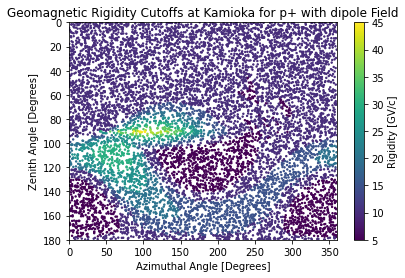

In [9]:
# evaluate for dipole field first
bfield_name_dip = "Dipole"
bfield_label_dip = "dipole"

result_arr_dip = evaluate(loc, plabel, rigidity_list, iter_num, bfield_name_dip)
label_params_dip = (locname, plabel, bfield_label_dip)
# plot scatter plot
plot_scatter(result_arr_dip, label_params_dip)

0 iterations done.
1000 iterations done.
2000 iterations done.
3000 iterations done.
4000 iterations done.
5000 iterations done.
6000 iterations done.
7000 iterations done.
8000 iterations done.
9000 iterations done.


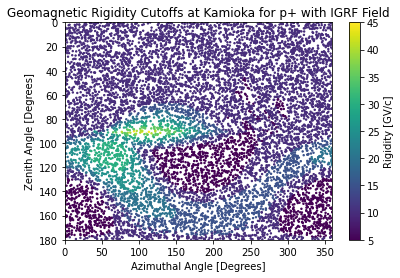

In [10]:
# evaluate for igrf field now
bfield_name_igrf = "igrf"
bfield_label_igrf = "IGRF"

result_arr_igrf = evaluate(loc, plabel, rigidity_list, iter_num, bfield_name_igrf)
label_params_igrf = (locname, plabel, bfield_label_igrf)
# plot scatter plot
plot_scatter(result_arr_igrf, label_params_igrf)

In [11]:
# interpolate results for 2-d plots
azimuth_grid, zenith_grid, rcgrid_dip = interpolate2d(result_arr_dip, ngrid_azimuth=65, ngrid_zenith=65)
azimuth_grid, zenith_grid, rcgrid_igrf = interpolate2d(result_arr_igrf, ngrid_azimuth=65, ngrid_zenith=65)

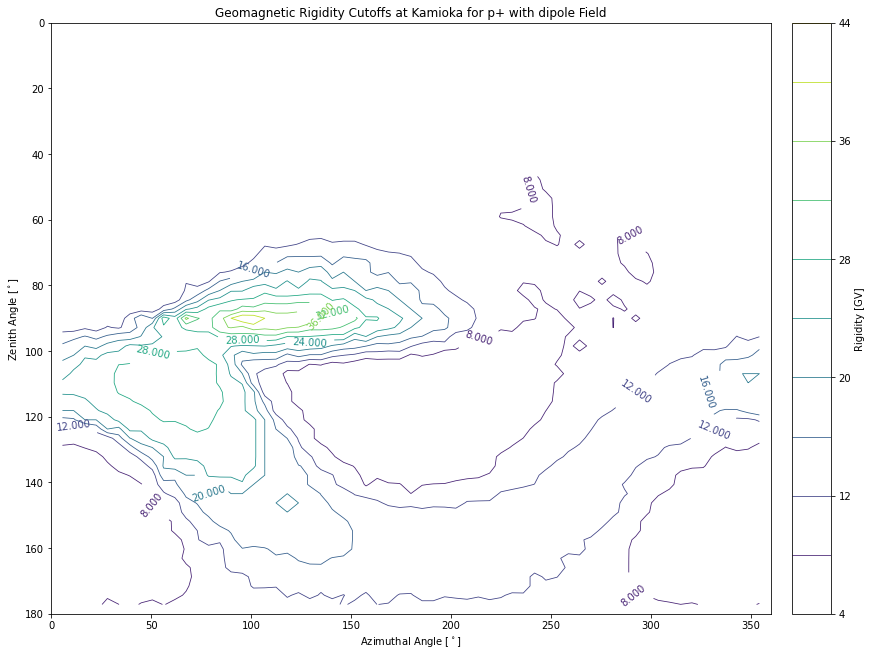

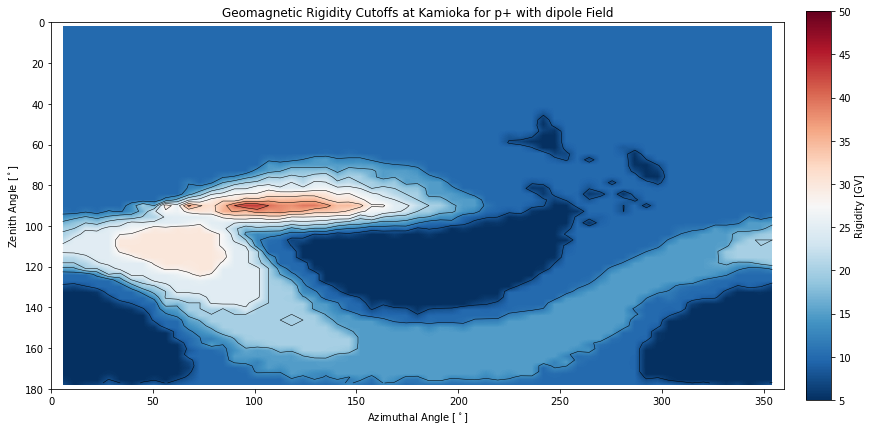

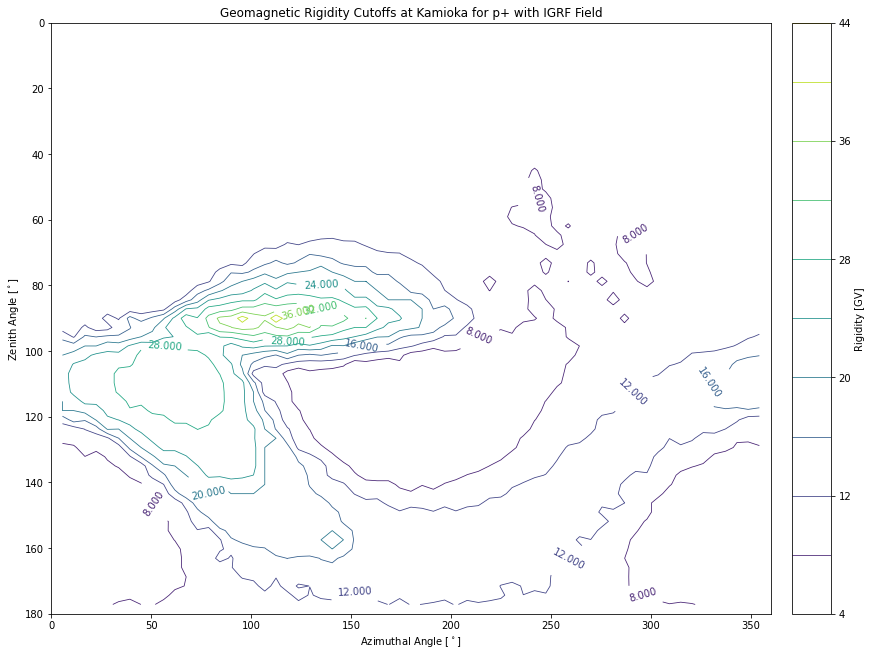

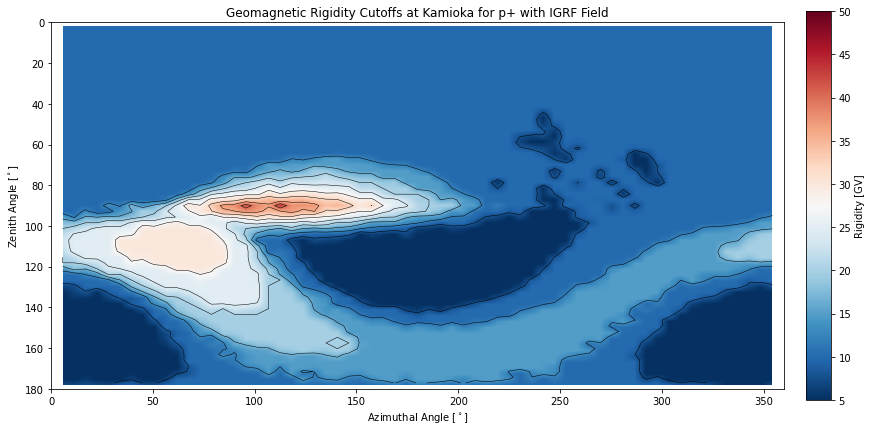

In [18]:
# dipole
# plot contour
plot_contour(azimuth_grid, zenith_grid, rcgrid_dip , label_params_dip)
# plot contour with imshow
plot_imcontour(azimuth_grid, zenith_grid, rcgrid_dip, label_params_dip)

# igrf 
# plot contour
plot_contour(azimuth_grid, zenith_grid, rcgrid_igrf, label_params_igrf)
# plot contour with imshow
plot_imcontour(azimuth_grid, zenith_grid, rcgrid_igrf, label_params_igrf)

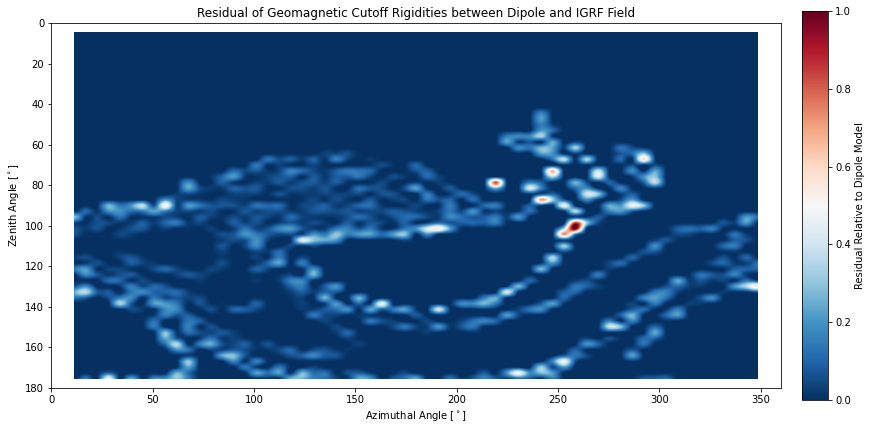

In [31]:
rcgrid_residual = np.abs(rcgrid_dip - rcgrid_igrf) / rcgrid_igrf

fig_res, ax_res = plt.subplots(figsize=(12, 9), constrained_layout=True)

image = ax_res.imshow(
    rcgrid_residual,
    extent=[-2.5, 362.5, -2.5, 182.5], 
    origin='upper',
    cmap="RdBu_r",
    interpolation="spline16",
    aspect="auto",
#     vmin=np.min(rigidity_list),
#     vmax=np.max(rigidity_list),
    alpha=1.
)
ax_res.axis('image')

# contour = ax_res.contour(
#     azimuth_grid,
#     zenith_grid,
#     rcgrid_residual,
#     colors="k",
#     linewidths=0.5,
# #     levels=len(rigidity_list),
#     alpha=1.
# )

cbar = fig_res.colorbar(image, ax=ax_res, shrink=0.6)
# cbar.ax.set_ylabel("Rigidity [GV]")
cbar.ax.set_ylabel("Residual Relative to IGRF Model")

ax_res.set_xlim([0., 360.])
ax_res.set_ylim([180., 0.])

ax_res.set_xlabel(r"Azimuthal Angle [$^\circ$]")
ax_res.set_ylabel(r"Zenith Angle [$^\circ$]")
ax_res.set_title("Residual of Geomagnetic Cutoff Rigidities between Dipole and IGRF Field")

# plt.savefig(os.path.join(PLOT_DIR, "gmcutoff_{0}_{1}_{2}_imcontourplot.png".format(*label_params)))
plt.savefig(os.path.join(PLOT_DIR, "gmcutoff_residual_imcontourplot.png"))

Current B-field type: Dipole
0 iterations done.
1000 iterations done.
2000 iterations done.
3000 iterations done.
4000 iterations done.
5000 iterations done.
6000 iterations done.
7000 iterations done.
8000 iterations done.
9000 iterations done.
Current B-field type: IGRF
0 iterations done.
1000 iterations done.
2000 iterations done.
3000 iterations done.
4000 iterations done.
5000 iterations done.
6000 iterations done.
7000 iterations done.
8000 iterations done.
9000 iterations done.


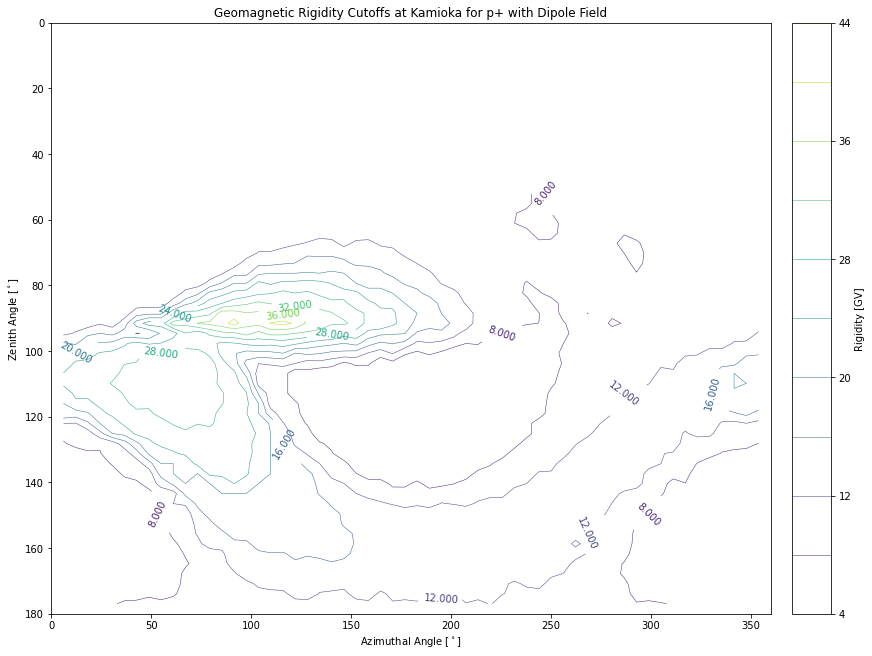

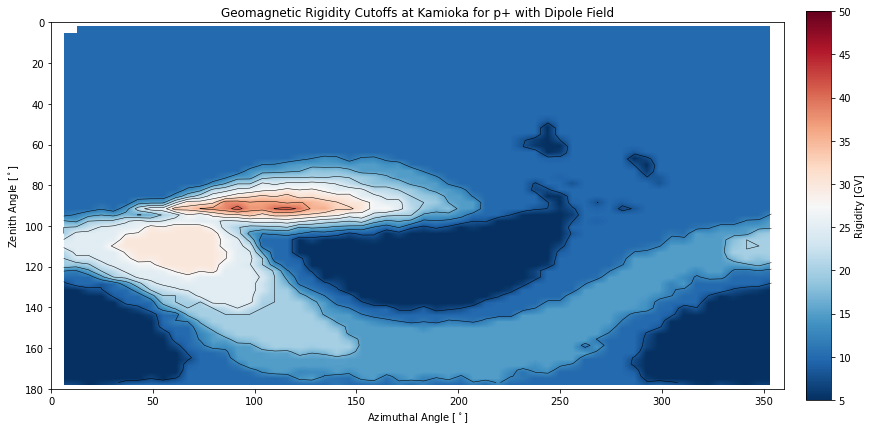

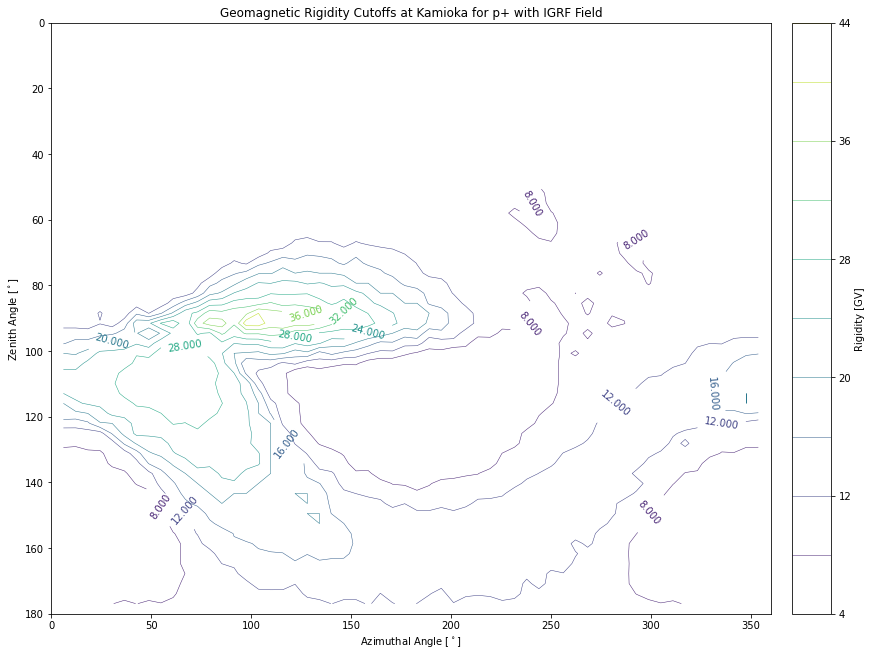

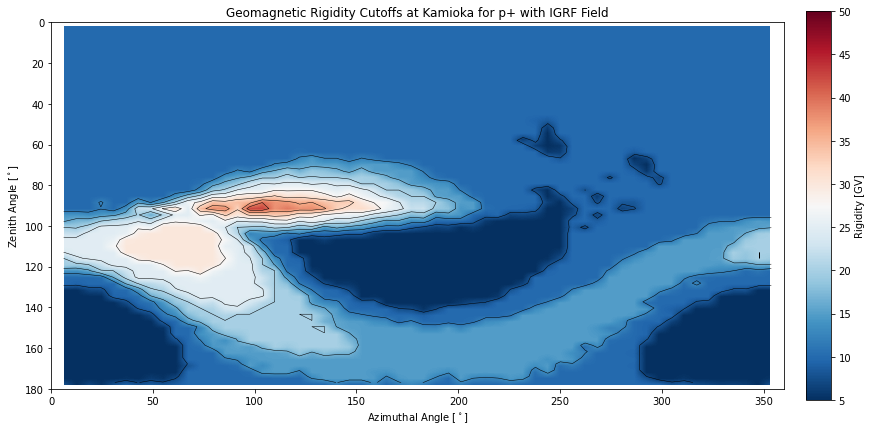

In [22]:
for (bfield_name, bfield_label) in bfield_list:
    print("Current B-field type: {:s}".format(bfield_label))
    result_arr = evaluate(loc, plabel, rigidity_list, iter_num, bfield_name)
    
    label_params = (locname, plabel, bfield_label)
#     print(label_params)
#     print("{0}_{1}_{2}".format(*label_params))
    
    # plot scatter plot
#     plot_scatter(result_arr, label_params)
    
    # plot contour
    plot_contour(result_arr, label_params)
    
    # plot contour with imshow
    plot_imcontour(result_arr, label_params)
    
    